<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%ED%94%84%EB%A1%A0%ED%8B%B0%EC%96%B4_%EC%99%84%EC%84%B12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Frontier Analysis

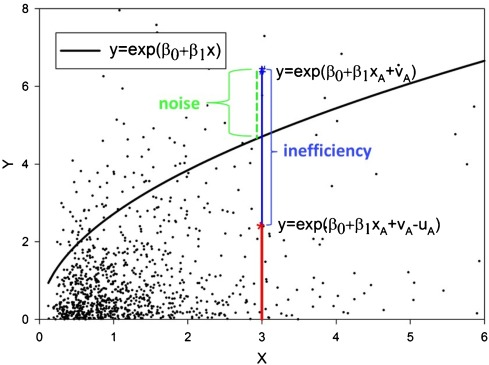

# Set up modules

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import scipy
from scipy.linalg import cholesky

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

# 저축은행 데이터

In [109]:
#!git clone https://github.com/hongjai-rhee/public.git
## 데이터 불러오기  
data = pd.read_csv('bank1_complete.csv')

data=data.dropna()
data.shape    # 결측치 제거

(816, 6)

In [ ]:
data

,code,index,year,Y,X1,X2
0,21,0,2008,71811.99986,433.000000,300.000000
1,21,0,2009,62676.00011,480.000000,201.000000
2,21,0,2010,55550.00027,398.000000,202.000000
3,21,0,2011,48154.00012,393.000000,196.000000
4,21,0,2012,48137.99976,362.000000,195.000000
...,...,...,...,...,...,...
811,99,67,2015,132600.00040,673.000000,801.000000
812,99,67,2016,264828.99900,1637.999999,1572.000000
813,99,67,2017,366404.00050,2207.999999,2069.000001
814,99,67,2018,393419.99900,2372.000000,2070.999999


In [110]:
unit_names = data.code.unique()   # county names 에서 unique 한 것만 뽑아라
unit_idx = data.code.values-21  # 카운티 이름을 숫자로 정렬하고, 숫자만 뽑음, 0부터 시작해야 함
n_unit=unit_names.shape[0]
N_firm=n_unit
N_year = len(data.year.unique())
N_year, N_firm

(12, 68)

# Y, X를 로그스케일로 변환하고 N_year * N_firm 매트릭스 형태로 배열

In [111]:
y=np.array([data.Y])
Y=np.reshape(np.log(y),(N_firm,N_year)).T

x1=np.array([data.X1])
X1=np.reshape(np.log(x1),(N_firm,N_year)).T

x2=np.array([data.X2])
X2=np.reshape(np.log(x2),(N_firm,N_year)).T

Y.shape

(12, 68)

# OLS

In [ ]:
with pm.Model() as pooled_model:

    # Priors 
    b = pm.Normal('b', 0, sigma=100, shape=3)

    u = pm.HalfCauchy('u', 5)

    y_mean = b[0] + b[1]*X1 + b[2]*X2

    # Data likelihood
    like = pm.Normal('like', y_mean, sigma=u, observed=Y)

In [ ]:
with pooled_model:
      trace1 = pm.sample(draws=2000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [u, b]
Sampling chain 0, 0 divergences:  13%|█▎        | 376/3000 [00:03<00:24, 106.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
import warnings
warnings.filterwarnings("ignore")

pm.traceplot(trace1)
pm.summary(trace1)

# Stochastic Frontier Model with time varying efficiencies

In [115]:
import theano.tensor as tt
N, D = Y.shape

sections = N_year

y_t  = theano.shared(Y )
x1_t = theano.shared(X1)
x2_t = theano.shared(X2)

# Create a section index
t_section = np.repeat(np.arange(sections), N/sections)
t_section_t = theano.shared(t_section)

with pm.Model() as model:
        v = pm.HalfCauchy('v', 5, shape=D)   
        var=tt.diag(v)

#        v = pm.HalfCauchy('v', 5, shape=1)
#        var=v*tt.eye(D)

        b = pm.Normal('b', mu=0, sd=10, shape=2)
        a = pm.MvGaussianRandomWalk('a', mu=0, shape=(sections, D), cov=var)

        a1=pm.Deterministic('a1', tt.max(a))
#        u1=pm.Deterministic('u1', a-a1)        
        eff=pm.Deterministic('eff', tt.exp(a-a1))
        
        alpha = a[t_section_t]
        y_mean = alpha + b[0]+x1_t + b[1]*x2_t 

        sd=pm.HalfCauchy('sd', 5)
#        sd = pm.Uniform('sd', 0, 1)
        like = pm.Normal('like', mu=y_mean, sigma=sd, observed=y_t)
        trace = pm.sample(3000, tune=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, a, b, v]
Sampling chain 0, 0 divergences: 100%|██████████| 5000/5000 [48:56<00:00,  1.70it/s]
The acceptance probability does not match the target. It is 0.907303501558531, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


# 모델 구조 보기

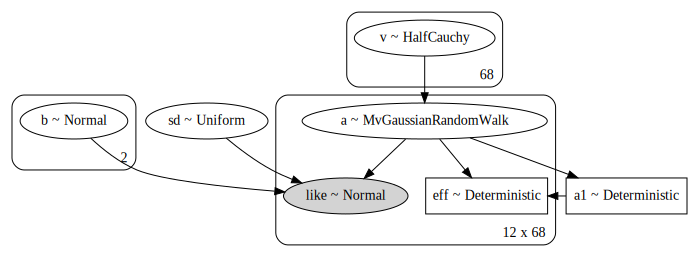

In [121]:
pm.model_to_graphviz(model)

# posterior sampling

# Graphical Summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],9.238,0.252,8.787,9.696,0.168,0.139,2.0,2.0,2.0,21.0,NaN
b[1],-0.584,0.030,-0.644,-0.532,0.019,0.016,2.0,2.0,2.0,38.0,NaN
"a[0,0]",-0.803,0.120,-1.038,-0.577,0.058,0.044,4.0,4.0,4.0,14.0,NaN
"a[0,1]",0.677,0.099,0.489,0.853,0.030,0.022,11.0,11.0,11.0,44.0,NaN
"a[0,2]",0.167,0.110,-0.047,0.378,0.043,0.031,7.0,7.0,7.0,19.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
"eff[11,64]",0.245,0.021,0.208,0.285,0.000,0.000,2444.0,2040.0,3224.0,1114.0,NaN
"eff[11,65]",0.034,0.004,0.027,0.041,0.002,0.001,4.0,4.0,4.0,42.0,NaN
"eff[11,66]",0.099,0.010,0.081,0.119,0.004,0.003,6.0,6.0,6.0,254.0,NaN
"eff[11,67]",0.072,0.009,0.057,0.089,0.004,0.003,4.0,4.0,4.0,50.0,NaN


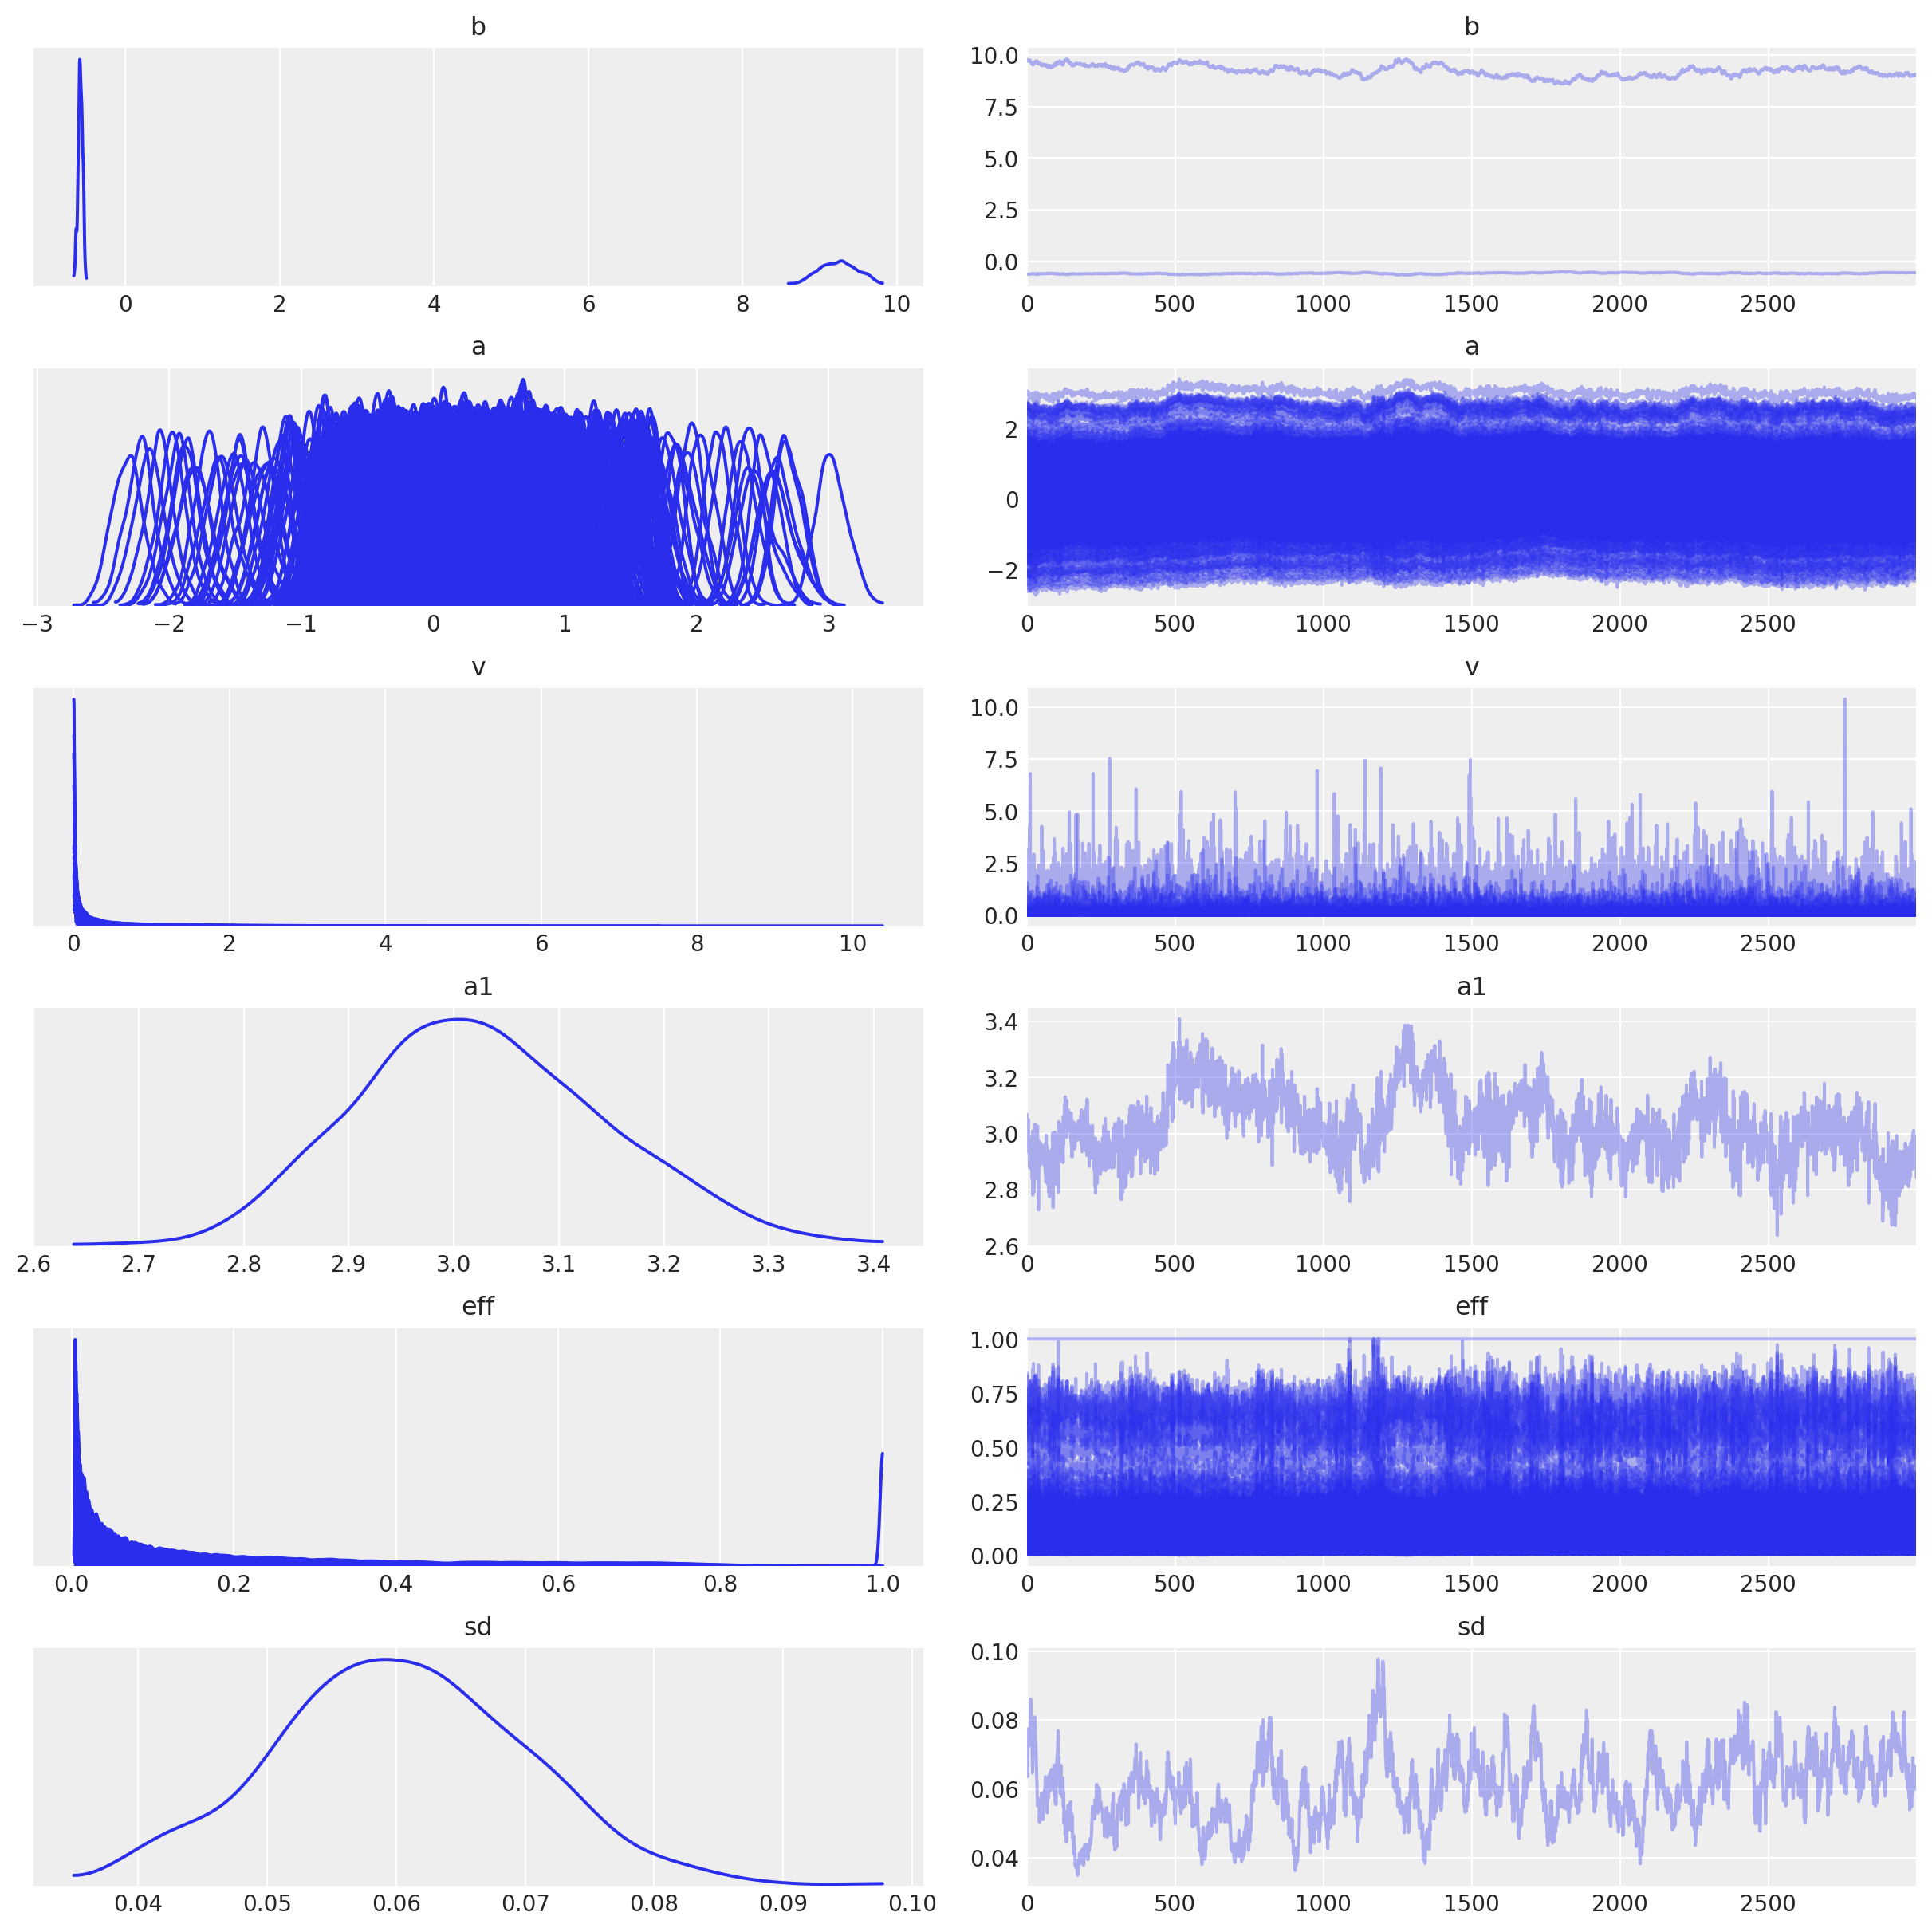

In [116]:
import warnings
warnings.filterwarnings("ignore")

pm.traceplot(trace)
pm.summary(trace)

# Change of Efficiency over time

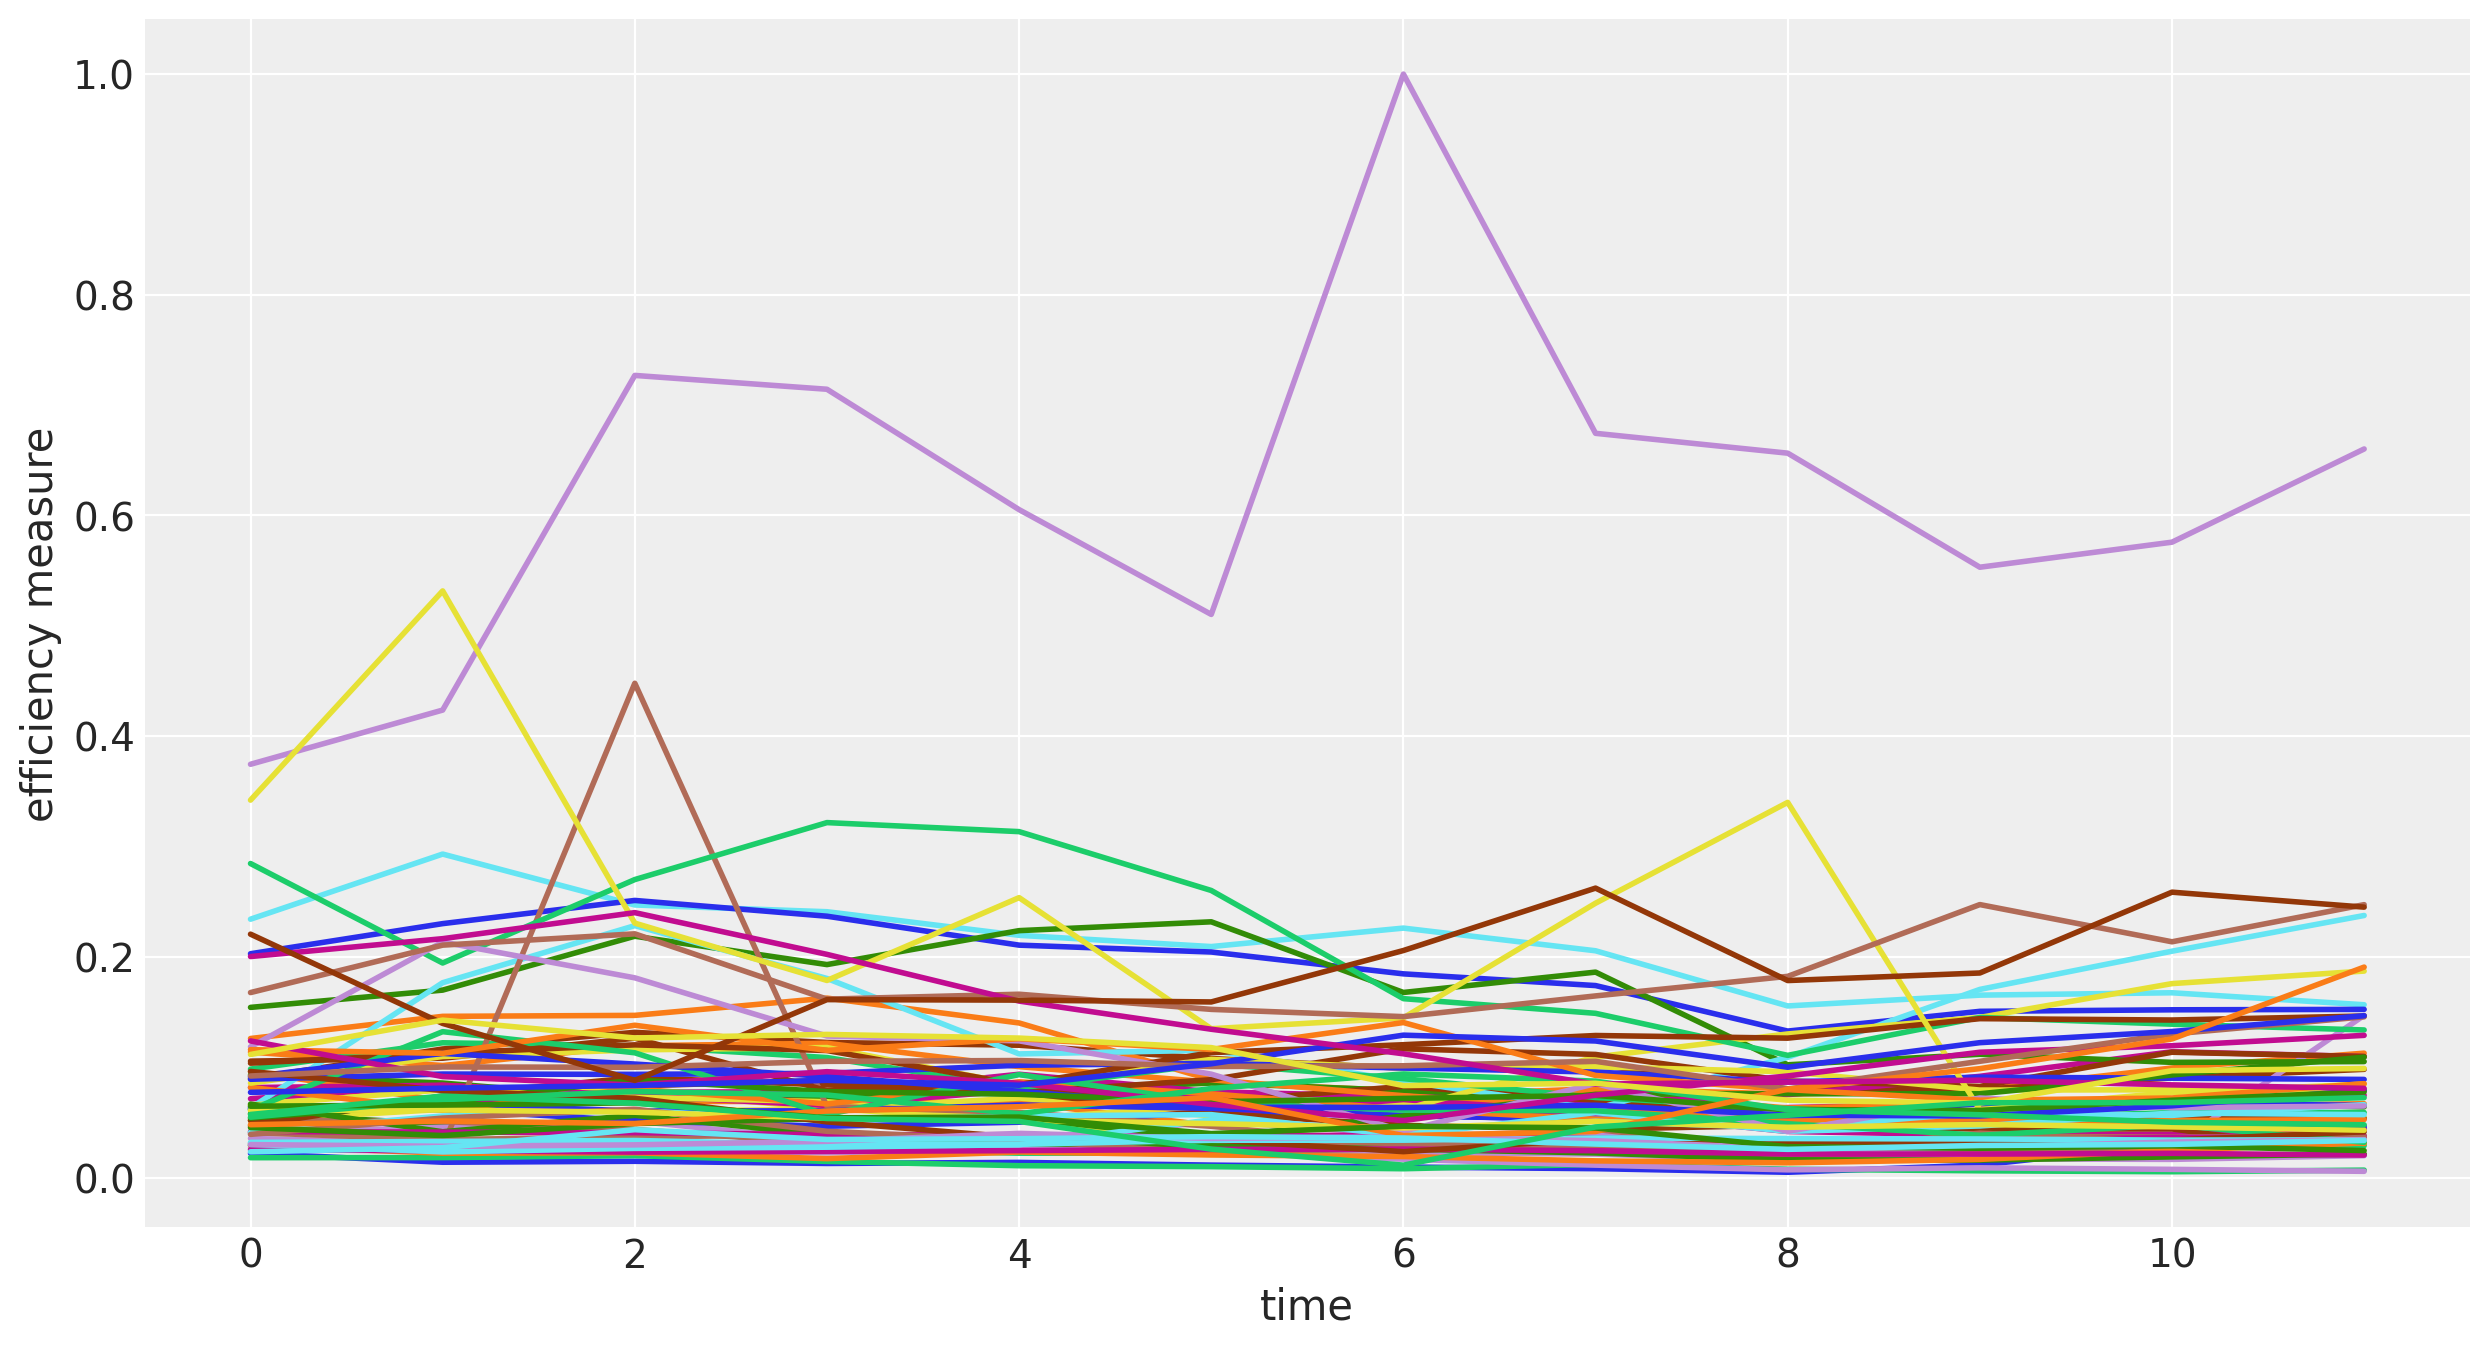

In [117]:
q=np.mean(trace.eff, axis=0)
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.xlabel('time')
plt.ylabel('efficiency measure')
#plt.rcParams['axes.grid'] = True
plt.plot(q)

In [120]:
pm.summary(trace, var_names='v')

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v[0],0.356,0.213,0.088,0.729,0.004,0.003,2770.0,2085.0,4836.0,2015.0,NaN
v[1],0.085,0.056,0.020,0.183,0.001,0.001,2498.0,2221.0,3081.0,2114.0,NaN
v[2],0.033,0.021,0.007,0.072,0.000,0.000,2672.0,2451.0,3397.0,2291.0,NaN
v[3],0.022,0.017,0.004,0.051,0.000,0.000,1913.0,1722.0,2119.0,2077.0,NaN
v[4],0.035,0.025,0.006,0.080,0.001,0.000,2173.0,2035.0,2364.0,1901.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
v[63],0.045,0.030,0.010,0.093,0.001,0.000,2630.0,2017.0,4731.0,2293.0,NaN
v[64],0.181,0.120,0.054,0.376,0.003,0.002,1925.0,1457.0,3499.0,2011.0,NaN
v[65],0.066,0.044,0.013,0.137,0.001,0.001,2770.0,2358.0,3616.0,2008.0,NaN
v[66],0.063,0.045,0.012,0.129,0.001,0.001,2544.0,2193.0,3258.0,2357.0,NaN
